# Modeling 30 day readmission
# A baseline model (BOW+XGBoost)

In [ ]:
!pip install bayesian-optimization

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
get_ipython().magic(u'matplotlib inline')
plt.style.use('ggplot')

## Loading preprocessed MIMIC-III data

In [ ]:
data_dir = "/content/drive/MyDrive/Notebooks_MIMIC/data"

In [ ]:
# load preprocessed notes
df_notes = pd.read_csv(os.path.join(data_dir,"preproc","admiss_notes.csv"))

In [ ]:
df_notes.head()

,TEXT,OUTPUT_LABEL
0,Admission Date: [**2101-10-20**] Discharg...,0
1,Admission Date: [**2191-3-16**] Discharge...,0
2,Admission Date: [**2175-5-30**] Dischar...,0
3,Admission Date: [**2178-4-16**] ...,0
4,"Name: [**Known lastname 9900**], [**Known fir...",0


## Data splitting

In [ ]:
# Balancing the dataset by subsampling

rows_pos = df_notes.OUTPUT_LABEL == 1
df_notes_pos = df_notes.loc[rows_pos]
df_notes_neg = df_notes.loc[~rows_pos]
# merge the balanced data
df_notes_bal = pd.concat([df_notes_pos, df_notes_neg.sample(n = len(df_notes_pos), random_state = 77)],axis = 0)
# shuffle the order of training samples 
df_notes_bal = df_notes_bal.sample(n = len(df_notes_bal), random_state = 77).reset_index(drop = True)
df_notes = df_notes_bal

In [ ]:
from sklearn.model_selection import train_test_split
# split into train and test
df_train, df_test = train_test_split(df_notes, random_state=77, test_size=0.30, shuffle=True)
# split test into test and validation datasets
df_test, df_valid = train_test_split(df_test, random_state=77, test_size=0.50, shuffle=True)

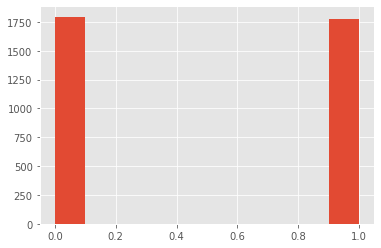

In [ ]:
# Prevalence
df_train.OUTPUT_LABEL.hist()

## Feature engineering (tokenization and vectorization)

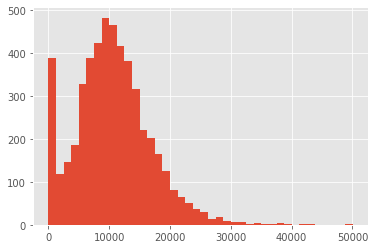

In [ ]:
# Text length distibution
df_notes["TEXT"].apply(len).hist(bins=40)

## Build a tokenizer

In [ ]:
import nltk
nltk.download("stopwords", quiet=True)
from nltk.corpus import stopwords
nltk.download('punkt', quiet=True)
from nltk import word_tokenize
from nltk.stem import PorterStemmer

In [ ]:
# English stop words
stops = list(stopwords.words('english'))
# adding new stops based on the analysis of the signif.features
stops = stops+['l','c','b','p','na']
print(stops)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
word_tokenize("Testing the tokenizer. Special characters are here + - *")

['Testing',
 'the',
 'tokenizer',
 '.',
 'Special',
 'characters',
 'are',
 'here',
 '+',
 '-',
 '*']

In [ ]:
import string
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [ ]:
stemmer = PorterStemmer()
def tokenizer(text):
    """
    On top of word_tokenizer, this tokenizer:
    replacing punctuation and numbers with spaces and lowercase all words
    """
    punc_list = string.punctuation+'0123456789'
    t = str.maketrans(dict.fromkeys(punc_list, " "))
    text = text.lower().translate(t)

    tokens = word_tokenize(text)
    tokens = [stemmer.stem(w) for w in tokens] # stem
    return tokens

In [ ]:
tokenizer('Special characters removed + - ; *')

['special', 'charact', 'remov']

## Build a vectorizer

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(max_features = 3000, 
                       tokenizer = tokenizer, 
                       stop_words = stops)
# this could take a while
vect.fit(df_train.TEXT.values)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=3000, min_df=1,
                ngram_range=(1, 1), preprocessor=None,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function tokenizer at 0x7f45d0b11830>,
                vocabulary=None)

In [ ]:
X_test_tf = vect.transform(df_test.TEXT.values)

In [ ]:
y_test = df_test.OUTPUT_LABEL

In [ ]:
# Transform notes into the vector format
X_train_tf = vect.transform(df_train.TEXT.values)
X_valid_tf = vect.transform(df_valid.TEXT.values)
X_test_tf = vect.transform(df_test.TEXT.values)

# Labels
y_train = df_train.OUTPUT_LABEL
y_valid = df_valid.OUTPUT_LABEL
y_test = df_test.OUTPUT_LABEL

In [ ]:
print(f"X_train_tf:{X_train_tf.shape} y_train:{len(y_train)}")
print(f"X_valid_tf:{X_valid_tf.shape} y_valid:{len(y_valid)}")

X_train_tf:(3568, 3000) y_train:3568
X_valid_tf:(765, 3000) y_valid:765


In [ ]:
# # Saving preproc arrays
# np.save(os.path.join(data_dir,"preproc","X_train_tf.npy"), X_train_tf)
# np.save(os.path.join(data_dir,"preproc","X_valid_tf.npy"), X_valid_tf)
# np.save(os.path.join(data_dir,"preproc","X_test_tf.npy"), X_test_tf)
# np.save(os.path.join(data_dir,"preproc","y_train.npy"), y_train)
# np.save(os.path.join(data_dir,"preproc","y_valid.npy"), y_valid)
# np.save(os.path.join(data_dir,"preproc","y_test.npy"), y_test)

In [ ]:
# # Load preproc arrays
# X_train_tf = np.load(os.path.join(data_dir,"preproc","X_train_tf.npy"), allow_pickle=True)
# X_valid_tf = np.load(os.path.join(data_dir,"preproc","X_valid_tf.npy"), allow_pickle=True)
# X_test_tf = np.load(os.path.join(data_dir,"preproc","X_test_tf.npy"), allow_pickle=True)
# y_train = np.load(os.path.join(data_dir,"preproc","y_train.npy"), allow_pickle=True)
# y_valid = np.load(os.path.join(data_dir,"preproc","y_valid.npy"), allow_pickle=True)
# y_test = np.load(os.path.join(data_dir,"preproc","y_test.npy"), allow_pickle=True)

## Selecting a model with the Bayesian hyperparameter optimization

https://www.kaggle.com/prashant111/a-guide-on-xgboost-hyperparameters-tuning

In [ ]:
!pip install hyperopt

In [ ]:
# import machine learning libraries
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

Parameters common for most tree-based learners:
- __max_depth__: The maximum depth per tree. A deeper tree might increase the performance, but also the complexity and chances to overfit.
The value must be an integer greater than 0. Default is 6.
- __learning_rate__: The learning rate determines the step size at each iteration while your model optimizes toward its objective. A low learning rate makes computation slower, and requires more rounds to achieve the same reduction in residual error as a model with a high learning rate. But it optimizes the chances to reach the best optimum.
The value must be between 0 and 1. Default is 0.3.
- __n_estimators__: The number of trees in our ensemble. Equivalent to the number of boosting rounds.
The value must be an integer greater than 0. Default is 100.
NB: In the standard library, this is referred as num_boost_round.
- __colsample_bytree__: Represents the fraction of columns to be randomly sampled for each tree. It might improve overfitting.
The value must be between 0 and 1. Default is 1.
-__subsample__: Represents the fraction of observations to be sampled for each tree. A lower values prevent overfitting but might lead to under-fitting.
The value must be between 0 and 1. Default is 1.

Regularization parameters:

- __alpha__ (reg_alpha): L1 regularization on the weights (Lasso Regression). When working with a large number of features, it might improve speed performances. It can be any integer. Default is 0.
- __lambda__ (reg_lambda): L2 regularization on the weights (Ridge Regression). It might help to reduce overfitting. It can be any integer. Default is 1.
- __gamma__: Gamma is a pseudo-regularisation parameter (Lagrangian multiplier), and depends on the other parameters. The higher Gamma is, the higher the regularization. It can be any integer. Default is 0.

In [ ]:
# Initialize domain space for range of values
space={
        'max_depth': hp.quniform("max_depth", 3, 10, 1),
        'learning_rate': hp.uniform('learning_rate', 0.01, 0.4),
        'n_estimators': hp.quniform('n_estimators', 50, 1000, 50),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.3, 1),
        'subsample' : hp.uniform('subsample', 0.3,1),
        'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
        'gamma': hp.uniform ('gamma', 0.0,0.5),
        'seed': 0
    }


In [ ]:
# Define objective function
def objective(space):
    clf=XGBClassifier(
                    objective='binary:logistic',
                    nthread=1,
                    seed=42,
                    max_depth = int(space['max_depth']), 
                    learning_rate = space['learning_rate'],
                    n_estimators = int(space['n_estimators']),
                    colsample_bytree=int(space['colsample_bytree']),
                    subsample = space['subsample'],
                    min_child_weight=int(space['min_child_weight']),
                    gamma = space['gamma'],
                    verbosity=1
                    )

    #evaluation = [( X_train_tf, y_train), ( X_valid_tf, y_valid)]
    # clf.fit(X_train_tf, y_train,
    #         eval_set=evaluation, 
    #         eval_metric="auc",
    #         early_stopping_rounds=10,
    #         verbose=False)
    
    clf.fit(X_train_tf, y_train)

    pred_val = clf.predict_proba(X_valid_tf)[:,1]
    pred_train = clf.predict_proba(X_train_tf)[:,1]

    accuracy = accuracy_score(y_valid, pred_val>0.5)
    auc_val = roc_auc_score(y_valid, pred_val)
    auc_train = roc_auc_score(y_train, pred_train)

    print (f"SCORE:{accuracy}  AUC_val:{auc_val}  AUC_train:{auc_train}")
    return {'loss': -auc_val, 'status': STATUS_OK, 'model': clf }

In [ ]:
# Optimization algorithm
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

SCORE:0.6248366013071895  AUC_val:0.6310114555993002  AUC_train:0.6771595599105744
SCORE:0.6235294117647059  AUC_val:0.6573333606736658  AUC_train:0.7046616926443857
SCORE:0.6418300653594772  AUC_val:0.6741784230096237  AUC_train:0.7781072321278477
SCORE:0.5947712418300654  AUC_val:0.6307790627734032  AUC_train:0.7301988823375076
SCORE:0.6169934640522876  AUC_val:0.6584816546369204  AUC_train:0.7357983494289928
SCORE:0.6274509803921569  AUC_val:0.685630604768154  AUC_train:0.8658087028108097
SCORE:0.5986928104575163  AUC_val:0.6364931922572179  AUC_train:0.7870078412334822
SCORE:0.6248366013071895  AUC_val:0.6940719324146982  AUC_train:0.8053713470550992
SCORE:0.6183006535947713  AUC_val:0.6606688812335957  AUC_train:0.7021332051336435
SCORE:0.6209150326797386  AUC_val:0.6590216262029746  AUC_train:0.7342646663744468
SCORE:0.5895424836601307  AUC_val:0.6245933125546808  AUC_train:0.7694821895124484
SCORE:0.592156862745098  AUC_val:0.6317598972003499  AUC_train:0.6934014865508156
SCORE:

In [ ]:
best_hyperparams

{'colsample_bytree': 0.7353917032926678,
 'gamma': 0.45341228298665115,
 'learning_rate': 0.1724007662996691,
 'max_depth': 3.0,
 'min_child_weight': 9.0,
 'n_estimators': 650.0,
 'subsample': 0.8776420887553404}

In [ ]:
# Best loss and a model
trials.results[np.argmin([r['loss'] for r in trials.results])]

{'loss': -0.6960541065179352,
 'model': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=0, gamma=0.45341228298665115,
               learning_rate=0.1724007662996691, max_delta_step=0, max_depth=3,
               min_child_weight=9, missing=None, n_estimators=650, n_jobs=1,
               nthread=1, objective='binary:logistic', random_state=0,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
               silent=None, subsample=0.8776420887553404, verbosity=1),
 'status': 'ok'}

In [ ]:
model_best = trials.results[np.argmin([r['loss'] for r in trials.results])]['model']

In [ ]:
y_train_preds = model_best.predict_proba(X_train_tf)[:,1]

In [ ]:
# calculate probability of readmission
y_train_preds = model_best.predict_proba(X_train_tf)[:,1]
y_valid_preds = model_best.predict_proba(X_valid_tf)[:,1]
y_test_preds = model_best.predict_proba(X_test_tf)[:,1]

## Calculate performance metrics

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [ ]:
def calc_accuracy(y_actual, y_pred, thresh=0.5):
    # this function calculates the accuracy with probability threshold at thresh
    return (sum((y_pred > thresh) & (y_actual == 1))+sum((y_pred < thresh) & (y_actual == 0))) /len(y_actual)

def calc_recall(y_actual, y_pred, thresh=0.5):
    # calculates the recall
    return sum((y_pred > thresh) & (y_actual == 1)) /sum(y_actual)

def calc_precision(y_actual, y_pred, thresh=0.5):
    # calculates the precision
    return sum((y_pred > thresh) & (y_actual == 1)) /sum(y_pred > thresh)

def calc_specificity(y_actual, y_pred, thresh=0.5):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def calc_prevalence(y_actual):
    # calculates prevalence
    return sum((y_actual == 1)) /len(y_actual)

In [ ]:
auc_train = roc_auc_score(y_train, y_train_preds)
auc_valid = roc_auc_score(y_valid, y_valid_preds)
auc_test = roc_auc_score(y_test, y_test_preds)

AUC = [auc_train, auc_valid, auc_test]

ACC = [calc_accuracy(y_train, y_train_preds),
       calc_accuracy(y_valid, y_valid_preds),
       calc_accuracy(y_test, y_test_preds)]

REC = [calc_recall(y_train, y_train_preds),
       calc_recall(y_valid, y_valid_preds),
       calc_recall(y_test, y_test_preds)]

PREC = [calc_precision(y_train, y_train_preds),
        calc_precision(y_valid, y_valid_preds),
        calc_precision(y_test, y_test_preds)]

SPEC = [calc_specificity(y_train, y_train_preds),
        calc_specificity(y_valid, y_valid_preds),
        calc_specificity(y_test, y_test_preds)]

PREV = [calc_prevalence(y_train),
        calc_prevalence(y_valid),
        calc_prevalence(y_test)]

df_summary = pd.DataFrame(list(zip(AUC, ACC, REC, PREC, SPEC, PREV)),
               columns =['AUC', 'ACC', 'REC', 'PREC', 'SPEC', 'PREVALENCE'], 
               index = ['train','valid','test'])

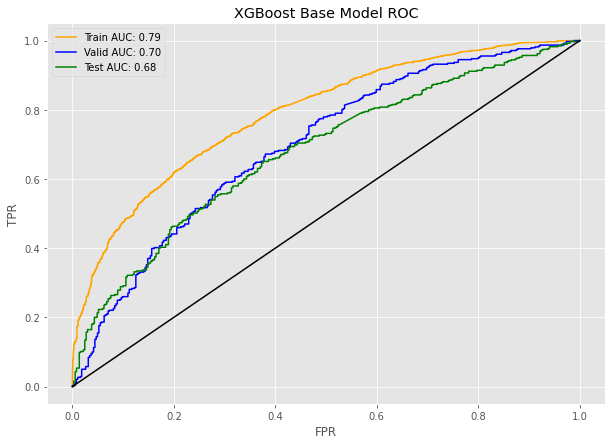

In [ ]:
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds)
fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_preds)

plt.rcParams["figure.figsize"] = (10,7)
plt.plot(fpr_train, tpr_train,'orange', label = f'Train AUC: {auc_train:.2f}')
plt.plot(fpr_valid, tpr_valid,'b',label = f'Valid AUC: {auc_valid:.2f}')
plt.plot(fpr_test, tpr_test,'g',label = f'Test AUC: {auc_test:.2f}')
plt.plot([0,1],[0,1],'k')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.title("XGBoost Base Model ROC")
plt.show()

In [ ]:
pd.options.display.float_format = '{:,.2f}'.format
df_summary

,AUC,ACC,REC,PREC,SPEC,PREVALENCE
train,0.79,0.71,0.66,0.73,0.76,0.50
valid,0.70,0.64,0.61,0.65,0.67,0.50
test,0.68,0.63,0.59,0.66,0.67,0.52


## Feature importance

In [ ]:
model_best

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0, gamma=0.45341228298665115,
              learning_rate=0.1724007662996691, max_delta_step=0, max_depth=3,
              min_child_weight=9, missing=None, n_estimators=650, n_jobs=1,
              nthread=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=None, subsample=0.8776420887553404, verbosity=1)

In [ ]:
model_best.feature_importances_

array([0.        , 0.        , 0.00155139, ..., 0.        , 0.        ,
       0.00125895], dtype=float32)

In [ ]:
from xgboost import plot_importance

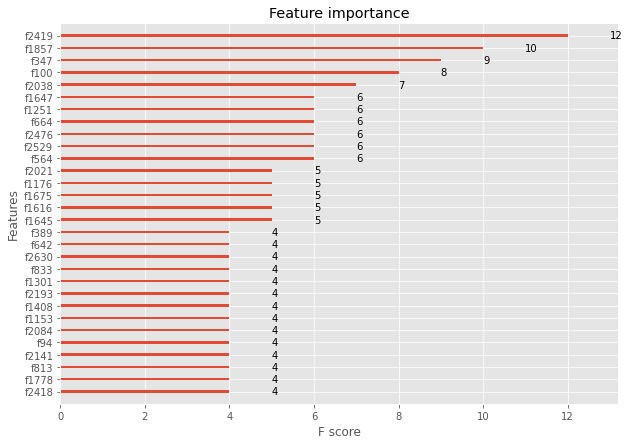

In [ ]:
plot_importance(model_best, max_num_features=30)

In [ ]:
# All features and their scores
all_feat = model_best.get_booster().get_score(importance_type='weight')

In [ ]:
all_feat_srt = sorted(all_feat.items(), key=lambda x: x[1], reverse=True)

In [ ]:
all_feat_srt[:20]

[('f2419', 12),
 ('f1857', 10),
 ('f347', 9),
 ('f100', 8),
 ('f2038', 7),
 ('f564', 6),
 ('f2529', 6),
 ('f2476', 6),
 ('f664', 6),
 ('f1251', 6),
 ('f1647', 6),
 ('f1645', 5),
 ('f1616', 5),
 ('f1675', 5),
 ('f1176', 5),
 ('f2021', 5),
 ('f560', 4),
 ('f2347', 4),
 ('f2189', 4),
 ('f579', 4)]

In [ ]:
index_to_word = {v:k for k,v in vect.vocabulary_.items()}

In [ ]:
for feat,score in all_feat_srt[:30]:
    print(index_to_word[int(feat[1:])])

sig
one
breath
also
po
concern
stent
sourc
day
hospit
mg
metoprolol
medic
ml
ha
pleas
compress
scan
rate
consult
ms
ct
wbc
chronic
spironolacton
side
ngt
drug
pulmonari
allergi
